In [97]:
import numpy as np
import scipy.io
import glob
from PIL import Image
import time
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, confusion_matrix
import pandas as pd
from utils import *


In [42]:
dataset_name = "pedestrians"
result_path = f"./dataset/results/{dataset_name}"
img_path = f"./dataset/baseline/{dataset_name}/"

# Ground Truth Files
gt_files = glob.glob(img_path + "groundtruth/*png")
gt_files.sort()

# Raw Image Failes
raw_files = glob.glob(img_path + "input/*jpg")
raw_files.sort()

In [43]:
k = 100
start_idx = 800

In [44]:
# Example Raw Image
raw_img = Image.open(raw_files[0])
raw_img = np.array(raw_img).astype(np.int32) / 255.0
p, q = raw_img.shape[0:2]

raw_batch = np.zeros((k, p * q))
gt_batch = np.zeros((k, p, q))
# middle_name = raw_files[start_idx + k // 2]

for img_idx in range(k):
    # Example Raw Image
    raw_img = Image.open(raw_files[start_idx + img_idx])
    raw_img = np.array(raw_img) / 255.0  # with shape (p, q, 3)
    raw_img = raw_img.mean(axis=-1)
    raw_batch[img_idx] = raw_img.ravel()
    
    # Ground Truth Image
    gt_img = Image.open(gt_files[start_idx + img_idx])
    gt_img = np.array(gt_img)  # with shape (p, q)
    gt_img *= (gt_img == 255)  # reserve the Moving class with value 255
    gt_img = gt_img.astype(np.float64) / 255.0
    gt_batch[img_idx] = gt_img

In [45]:
# np.save("./raw_batch.npy", raw_batch)

In [47]:
## load model
# model_path = "./models/LRPCA-main/synthetic_data_exp/trained_models/lrpcanet_alpha0.1.mat";
model_path = "/mnt/MineSafe-2024/LRPCA.mat";
model = scipy.io.loadmat(model_path)

ths = model['ths'].reshape(-1)
step = model['step'].reshape(-1)

r = 5
n = k

In [49]:
zeta = ths * (1000/n) * (r/5);              # thresholds (adaptive to n,r)
eta  = step;                                # step sizes

In [50]:
# Soft Thresholding
def Thre(M, tau):
    return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

In [86]:
def LearnedRPCA(Y, r, zeta, eta):
    # preparation
    T = zeta.shape[0]
    
    # Initialization
    tStart = time.time()
    U, S, V = np.linalg.svd(Y - Thre(Y, zeta[0]), full_matrices=False)
    
    U0 = U[:, 0:r]
    Sigma0 = np.diag(S[:r])
    V0 = V[0:r, :]
    L = U0 @ np.sqrt(Sigma0)
    R = np.transpose(V0) @ np.sqrt(Sigma0)
    print("===============LRPCA logs=============\n")
    for t in range(1, T):
        t3 = time.time()
        X = L @ np.transpose(R)
        S = Thre(Y - X, zeta[t])
        L_plus = L - eta[t] * (X + S - Y) @ R @ np.linalg.inv(np.transpose(R) @ R + 2.2204e-16 * np.diag(np.ones(r)))
        R_plus = R - eta[t] * np.transpose(X + S - Y) @ L @ np.linalg.inv(np.transpose(L) @ L + 2.2204e-16 * np.diag(np.ones(r)))
        L = L_plus
        R = R_plus
        t4 = time.time()
#         dist_X = norm(X - X_star, 'fro')/norm(X_star, 'fro');
        print(f"k: {t}; Time: {t4-t3:.4f}\n");
    final_X = L @ np.transpose(R)
    return X

In [87]:
lrpac_thres = -0.1

In [52]:
t1 = time.time()
X = LearnedRPCA(raw_batch, r, zeta, eta)
foreground = raw_batch - X
mask = (foreground < lrpac_thres) * 1.0
mask = mask.reshape(-1, p, q)
t2 = time.time()

===============LRPCA logs=============

k: 1; Time: 0.2114

k: 2; Time: 0.2125

k: 3; Time: 0.2128

k: 4; Time: 0.2122



In [53]:
(t2 - t1) / 100

0.017331364154815673

In [105]:
idx = 0

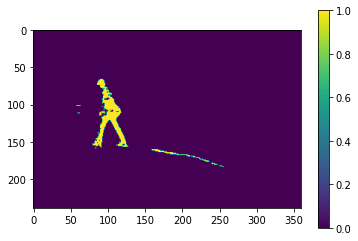

In [106]:
plt.imshow(mask[idx])
plt.colorbar()

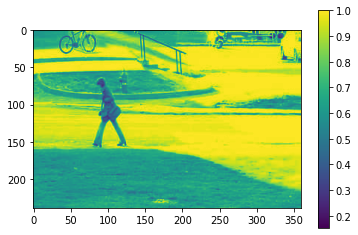

In [107]:
plt.imshow(raw_batch[idx].reshape((p, q)))
plt.colorbar()

In [77]:
y_predict = mask.ravel()
y_true = gt_batch.ravel()

tn, fp, fn, tp = confusion_matrix(y_true, y_predict).ravel()  # confusion matrix
print(tn, fp, fn, tp)

8561244 14563 27134 37059


In [78]:
P = tp / (tp + fp)
R = tp / (tp + fn)
P, R

(0.7178915966060981, 0.5773059367843846)

In [80]:
f1 = 2 * P * R / (P + R)                              # F1-score
print(f1, R)

0.6399689159435306 0.5773059367843846


# Evaluate the whole video

In [92]:
results_list = []

In [93]:
ww = 100  # window width
lrpac_thres = -0.1

start_idx = 0
end_idx = start_idx + ww

In [94]:
while (start_idx < len(raw_files)):
    print(f"================================[Frame {start_idx}-{end_idx}]================================")
    # read window
    k = end_idx - start_idx  # this window's width, which may be smaller than ww in the last window
    raw_batch = np.zeros((k, p * q))
    gt_batch = np.zeros((k, p, q))
    for img_idx in range(k):
        # Raw Image Batch
        raw_img = Image.open(raw_files[start_idx + img_idx])
        raw_img = np.array(raw_img) / 255.0  # with shape (p, q, 3)
        raw_img = raw_img.mean(axis=-1)      # with shape (p, q)
        raw_batch[img_idx] = raw_img.ravel() # with shape (p * q)

        # Ground Truth Image Batch
        gt_img = Image.open(gt_files[start_idx + img_idx])
        gt_img = np.array(gt_img)  # with shape (p, q)
        gt_img *= (gt_img == 255)  # reserve the Moving class with value 255
        gt_img = gt_img.astype(np.float64) / 255.0
        gt_batch[img_idx] = gt_img
    
    ###################### LRPCA ######################
    # 1. build the LRPCA model and fitting
    t1 = time.time()
    X = LearnedRPCA(raw_batch, r, zeta, eta)
    # 3. thresholding
    foreground = raw_batch - X
    mask = (foreground < lrpac_thres) * 1.0
    mask = mask.reshape(-1, p, q)
    t2 = time.time()
    lrpca_time = t2 - t1
    print(f"- fitting the LRPCA model time cost: {lrpca_time: .4f}")
    
    # evaluate the metrics for this whole window
    y_predict = mask.ravel()
    y_true = gt_batch.ravel()
    conf_mat = confusion_matrix(y_true, y_predict).ravel()  # confusion matrix
    if len(conf_mat) == 1:
        tn, fp, fn, tp = conf_mat[0], 0, 0, 0
    else:
        tn, fp, fn, tp = conf_mat
    
    # record the results
    results_list.append([k, lrpca_time, tn, fp, fn, tp])
    results_df = pd.DataFrame(results_list, columns=["k", "lrpca_time", "tn", "fp", "fn", "tp"])
    results_df.to_csv(f"./results/lrpca-{dataset_name}.csv")
    
    # update window index
    start_idx = end_idx
    end_idx = min(end_idx + ww, len(raw_files))

================================[Frame 0-100]================================
===============LRPCA logs=============

k: 1; Time: 0.2140

k: 2; Time: 0.2137

k: 3; Time: 0.2130

k: 4; Time: 0.2128

- fitting the LRPCA model time cost:  1.7483
================================[Frame 100-200]================================
===============LRPCA logs=============

k: 1; Time: 0.2143

k: 2; Time: 0.2132

k: 3; Time: 0.2133

k: 4; Time: 0.2163

- fitting the LRPCA model time cost:  1.7712
================================[Frame 200-300]================================
===============LRPCA logs=============

k: 1; Time: 0.2167

k: 2; Time: 0.2169

k: 3; Time: 0.2172

k: 4; Time: 0.2163

- fitting the LRPCA model time cost:  1.7844
================================[Frame 300-400]================================
===============LRPCA logs=============

k: 1; Time: 0.2128

k: 2; Time: 0.2128

k: 3; Time: 0.2131

k: 4; Time: 0.2132

- fitting the LRPCA model time cost:  1.7817
======================

- F1 score

In [98]:
total_fp = results_df.fp.sum()
total_fn = results_df.fn.sum()
total_tp = results_df.tp.sum()

In [99]:
f1, Recall, Precision = compute_metrics(total_fp, total_fn, total_tp)
f1, Recall, Precision

(0.6727511239709907, 0.7246959881465935, 0.6277548227151822)

- Average time:

In [101]:
total_time = results_df.lrpca_time.sum()
n = results_df.k.sum()

In [102]:
avg_time = total_time / n
avg_time

0.017660495256488166